# Approximate conditionals

Though restricted to Gaussian operation, `GT` can also be used for non Gaussian conditionals. The only requirement is, that the affine transformations are defined in some way, even if that is only approximately. `GT`provides some examples, where the affine transformations can be appoximated by moment matching. In this notebook we showcase these `approximate_conditionals` by a simple example. Let's consider a the infamous MNIST dataset, a dataset of handwritten digits.

In [1]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler 
from jax import config
from matplotlib import pyplot as plt
from gaussian_toolbox import approximate_conditional, pdf
from jax import numpy as jnp
import numpy as np
from gaussian_toolbox.utils.jax_minimize_wrapper import minimize

np.random.seed(42)
config.update("jax_enable_x64", True)

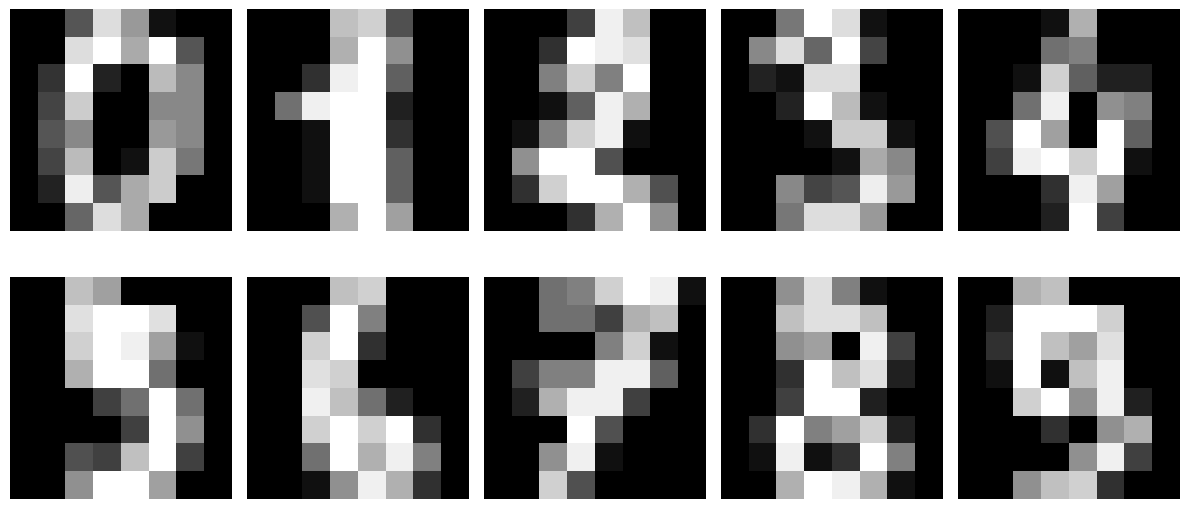

In [2]:
mnist = load_digits()
X, y = mnist['data'], mnist['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
N, Dx = X_scaled.shape

num_data_to_show = 10
plt.figure(figsize=(12, 6))
for isample in range(num_data_to_show):
    ax = plt.subplot(2, num_data_to_show//2,isample + 1)
    ax.axis('off')
    plt.imshow(scaler.inverse_transform(X_scaled)[isample].reshape(8,8), cmap='gray')
plt.tight_layout()

Here, we define a simple latent variable model of the form

$$
p(X\vert \Phi) = \int p(X\vert Z, \Phi)p(Z){\rm d} Z,
$$

where $X$ is the image data, and $Z$ some latent variable. The distribution over the latent space we consider standard normal. Let's first define this object in `GT`.


In [3]:
# Dimensions of latent space
Dz = 3
Sigma_z, mu_z = jnp.array([jnp.eye(Dz)]), jnp.zeros((1, Dz))
p_z = pdf.GaussianPDF(Sigma=Sigma_z, mu=mu_z)

Now it remains to clarify what is $p(X\vert Z, \Phi)$. Here we consider a Gaussian with non-linear mean
$$
\mu(Z) = W \phi(Z),
$$
where the feature vector is a vector $(1, z_1, \ldots, z_{D_z}, f_1(Z), \ldots, f_K(Z))^\top$ and $f_i$ are radial basis function kernels. For this model, we can do [moment matching](https://proceedings.neurips.cc/paper/1998/hash/0ebcc77dc72360d0eb8e9504c78d38bd-Abstract.html), i.e. define the output of the affine transformation with the Gaussian that has the first two moments equal to the exact density. $\Phi$ denotes all the parameters of the conditional ($W$, the kernel parameters, and the covariance). Let's construct this object.

In [4]:
num_kernels = 50

params = {'log_sigma': jnp.log(jnp.array([1.])),
          'M': jnp.array(1e-2 * np.random.randn(1, Dx, Dz + num_kernels)),
          'b': jnp.zeros([1, Dx]),
          'log_length_scale': jnp.array([0.]),
          'mu': jnp.array(np.random.randn(num_kernels, Dz))}
Sigma_x = jnp.array(jnp.eye(Dx))

def create_conditional(params):
    Sigma_x = jnp.array([jnp.exp(params['log_sigma']) * jnp.eye(Dx)])
    Lambda_x = jnp.array([jnp.exp(-params['log_sigma']) * jnp.eye(Dx)])
    ln_det_Sigma_x = jnp.array([params['log_sigma'] * Dx])
    length_scale = jnp.array(jnp.exp(params['log_length_scale']) * jnp.ones([num_kernels, Dz]))
    return approximate_conditional.LRBFGaussianConditional(M = params['M'], b = params['b'], mu=params['mu'], length_scale=length_scale, Sigma=Sigma_x, Lambda=Lambda_x, ln_det_Sigma=ln_det_Sigma_x)

Now, we wish to learn the model parameters $\Phi$ by minimizing the negative log-likelihood. The log-likelihood is given by

$$
\ell(X,\phi) = \sum_i \ln \int p(X_i\vert Z, \Phi)p(Z){\rm d} Z,
$$
which involves the `affine_marginal_transform`. Again with `GT` this is done with minimal code.

In [5]:
def get_neg_likelihood(params, X):
    cond_x_given_z = create_conditional(params)
    return -jnp.mean(cond_x_given_z.affine_marginal_transformation(p_z).evaluate_ln(X))

An that is it. Now we just minimize our objective and learn the model.

In [6]:
result = minimize(get_neg_likelihood, params, method='L-BFGS-B', args=(X_scaled,), options={})
p_x_given_z_opt = create_conditional(result.x)

With the learnt model we also project the data back into the latent space, by the `affine conditional transformation` and then condition on the data (which gives us the equivalent of the encoder in a variational auto encoder (VAE)).

In [7]:
p_z_given_x = p_x_given_z_opt.affine_conditional_transformation(p_z)
p_z_given_X = p_z_given_x(X_scaled)

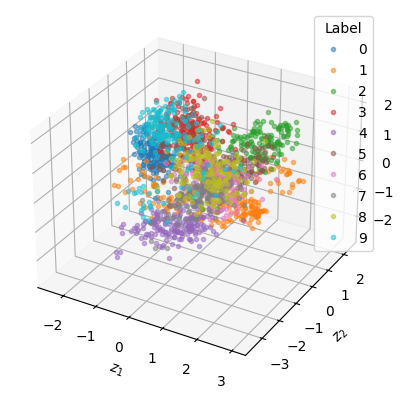

In [8]:
ax = plt.subplot(111,projection='3d')
for label in range(10):
    
    plt.plot(p_z_given_X.mu[y==label,0], p_z_given_X.mu[y==label,1], p_z_given_X.mu[y==label,2], '.', label=label, alpha=.5)
plt.legend(title='Label')
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')
ax.set_zlabel('$z_3$')
plt.show()

We see that the different digits are clustered int the latent space. We can also see, whether samples from the model look reasonable.

In [9]:
from jax import random
key = random.PRNGKey(42)
key, subkey = random.split(key)

num_samples = 10
z_sample = p_z.sample(subkey, num_samples)[:,0]
key, subkey = random.split(key)
x_sample = scaler.inverse_transform(p_x_given_z_opt(z_sample).sample(subkey, 1)[0])

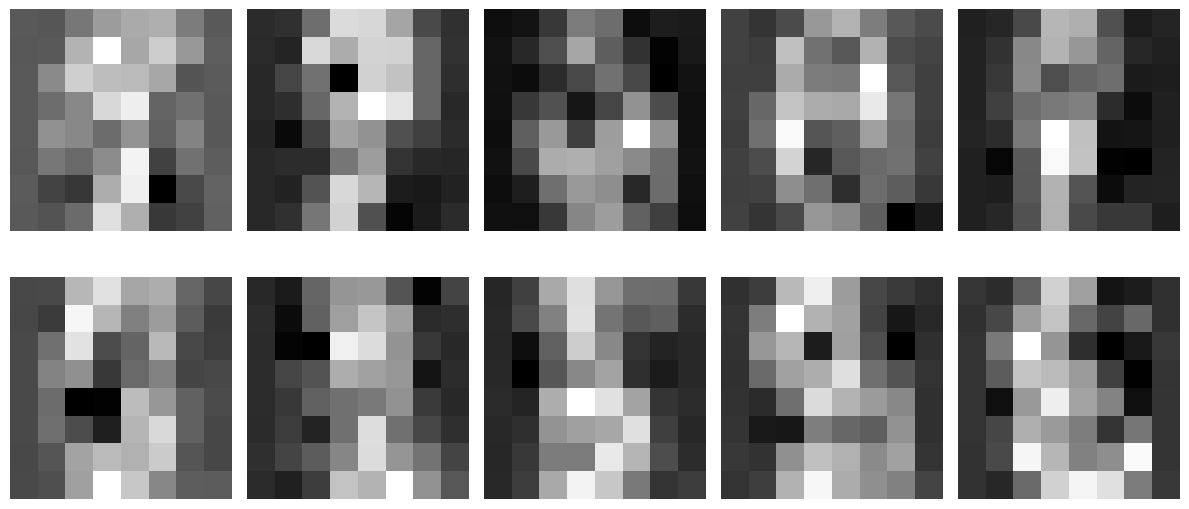

In [10]:
plt.figure(figsize=(12, 6))
for isample in range(num_samples):
    ax = plt.subplot(2, num_samples//2,isample + 1)
    ax.axis('off')
    plt.imshow(x_sample[isample].reshape(8,8), cmap='gray')
plt.tight_layout()

While the sample seem a bit blurry, they definitely sample some structure. But of course, we are looking at a very simple model. Maybe you can find a better one? ;)